### Compare SOM algorithm with SOMz

SOMz is a module that is part of MLZ (https://github.com/mgckind/MLZ). The core elements of the module have been copied to this notebook and made python-3 compatible in order to debug issues with our current SOM algorithm.

More on the SOMz module here: http://matias-ck.com/mlz/somz.html

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy
import copy
import sys, os, random
import warnings

warnings.simplefilter("ignore", RuntimeWarning)
try:
    import somF
    SF90 = True
except:
    SF90 = False

In [3]:
def get_index(ix, iy, nx, ny):
    return iy * nx + ix


def get_pair(ii, nx, ny):
    iy = int(numpy.floor(ii / nx))
    ix = ii % nx
    return ix, iy


def get_ns(ix, iy, nx, ny, index=False):
    """
    Get neighbors for rectangular grid given its
    coordinates and size of grid

    :param int ix: Coordinate in the x-axis
    :param int iy: Coordinate in the y-axis
    :param int nx: Number fo cells along the x-axis
    :param int ny: Number fo cells along the y-axis
    :param bool index: Return indexes in the map format
    :return: Array of indexes for direct neighbors
    """
    ns = []
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy + 1 < ny: ns.append((ix, iy + 1))

    if ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    if ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))

    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def get_ns_hex(ix, iy, nx, ny, index=False):
    """
    Get neighbors for hexagonal grid given its coordinates
    and size of grid
    Same parameters as :func:`get_ns`
    """
    ns = []
    even = False
    if iy % 2 == 0: even = True
    if ix - 1 >= 0: ns.append((ix - 1, iy))
    if ix + 1 < nx: ns.append((ix + 1, iy))
    if iy - 1 >= 0: ns.append((ix, iy - 1))
    if iy + 1 < ny: ns.append((ix, iy + 1))
    if even and ix - 1 >= 0 and iy - 1 >= 0: ns.append((ix - 1, iy - 1))
    if even and ix - 1 >= 0 and iy + 1 < ny: ns.append((ix - 1, iy + 1))
    if not even and ix + 1 < nx and iy - 1 >= 0: ns.append((ix + 1, iy - 1))
    if not even and ix + 1 < nx and iy + 1 < ny: ns.append((ix + 1, iy + 1))
    ns = numpy.array(ns)
    if not index:
        return ns
    if index:
        ins = []
        for i in range(len(ns)):
            ins.append(get_index(ns[i, 0], ns[i, 1], nx, ny))
        return numpy.array(ins)


def geometry(top, Ntop, periodic='no'):
    """
    Pre-compute distances between cells in a given topology
    and store it on a distLib array

    :param str top: Topology ('grid','hex','sphere')
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :return: 2D array with distances pre computed between cells and total number of units
    :rtype: 2D float array, int
    """
    if top == 'sphere':
        try:
            import healpy as hpx
        except:
            print('Error: healpy module not found, use grid or hex topologies')
            sys.exit(0)
    if top == 'sphere':
        nside = Ntop
        npix = 12 * nside ** 2
        distLib = numpy.zeros((npix, npix))
        for i in range(npix):
            ai = hpx.pix2ang(nside, i)
            for j in range(i + 1, npix):
                aj = hpx.pix2ang(nside, j)
                distLib[i, j] = hpx.rotator.angdist(ai, aj)
                distLib[j, i] = distLib[i, j]
        distLib[numpy.where(numpy.isnan(distLib))] = numpy.pi
    if top == 'grid':
        nx = Ntop
        ny = Ntop
        npix = nx * ny
        mapxy = numpy.mgrid[0:1:complex(0, nx), 0:1:complex(0, ny)]
        mapxy = numpy.reshape(mapxy, (2, npix))
        bX = mapxy[1]
        bY = mapxy[0]
        dx = 1. / (nx - 1)
        dy = 1. / (ny - 1)
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 1. + dy)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] + 0.)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - 1. - dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0.)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + 1. + dx)) ** 2 + (bY[i] - (bY[j] - 1. - dy)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    if top == 'hex':
        nx = Ntop
        ny = Ntop
        xL = numpy.arange(0, nx, 1.)
        dy = 0.8660254
        yL = numpy.arange(0, ny, dy)
        ny = len(yL)
        nx = len(xL)
        npix = nx * ny
        bX = numpy.zeros(nx * ny)
        bY = numpy.zeros(nx * ny)
        kk = 0
        last = ny * dy
        for jj in range(ny):
            for ii in range(nx):
                if jj % 2 == 0: off = 0.
                if jj % 2 == 1: off = 0.5
                bX[kk] = xL[ii] + off
                bY[kk] = yL[jj]
                kk += 1
        distLib = numpy.zeros((npix, npix))
        if periodic == 'no':
            for i in range(npix):
                for j in range(i + 1, npix):
                    distLib[i, j] = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    distLib[j, i] = distLib[i, j]
        if periodic == 'yes':
            for i in range(npix):
                for j in range(i + 1, npix):
                    s0 = numpy.sqrt((bX[i] - bX[j]) ** 2 + (bY[i] - bY[j]) ** 2)
                    s1 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - bY[j]) ** 2)
                    s2 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s3 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s4 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + last)) ** 2)
                    s5 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] + 0)) ** 2)
                    s6 = numpy.sqrt((bX[i] - (bX[j] - nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s7 = numpy.sqrt((bX[i] - (bX[j] + 0)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    s8 = numpy.sqrt((bX[i] - (bX[j] + nx)) ** 2 + (bY[i] - (bY[j] - last)) ** 2)
                    distLib[i, j] = numpy.min((s0, s1, s2, s3, s4, s5, s6, s7, s8))
                    distLib[j, i] = distLib[i, j]
    return distLib, npix


def is_power_2(value):
    """
    Check if passed value is a power of 2
    """
    return value!=0 and ((value & (value- 1)) == 0)


def get_alpha(t, alphas, alphae, NT):
    """
    Get value of alpha at a given time
    """
    return alphas * numpy.power(alphae / alphas, float(t) / float(NT))


def get_sigma(t, sigma0, sigmaf, NT):
    """
    Get value of sigma at a given time
    """
    return sigma0 * numpy.power(sigmaf / sigma0, float(t) / float(NT))


def h(bmu, mapD, sigma):
    """
    Neighborhood function which quantifies how much cells around the best matching one are modified

    :param int bmu: best matching unit
    :param float mapD: array of distances computed with :func:`geometry`
    """
    return numpy.exp(-(mapD[bmu] ** 2) / sigma ** 2)

In [182]:
class SelfMap():
    """
    Create a som class instance

    :param float X: Attributes array (all columns used)
    :param float Y: Attribute to be predicted (not really needed, can be zeros)
    :param str topology: Which 2D topology, 'grid', 'hex' or 'sphere'
    :param str som_type: Which updating scheme to use 'online' or 'batch'
    :param int Ntop: Size of map,  for grid Size=Ntop*Ntop,
        for hex Size=Ntop*(Ntop+1[2]) if Ntop is even[odd] and for sphere
        Size=12*Ntop*Ntop and top must be power of 2
    :param  int iterations: Number of iteration the entire sample is processed
    :param str periodic: Use periodic boundary conditions ('yes'/'no'), valid for 'hex' and 'grid' only
    :param dict dict_dim: dictionary with attributes names
    :param float astar: Initial value of alpha
    :param float aend: End value of alpha
    :param str importance: Path to the file with importance ranking for attributes, default is none
    """

    def __init__(self, X, Y, topology='grid', som_type='online', Ntop=28, iterations=30, periodic='no', dict_dim='',
                 astart=0.8, aend=0.5, importance=None):
        self.np, self.nDim = numpy.shape(X)
        self.dict_dim = dict_dim
        self.X = X
        self.SF90 = SF90
        self.Y = Y
        self.aps = astart
        self.ape = aend
        self.top = topology
        if topology=='sphere' and not is_power_2(Ntop):
            print('Error, Ntop must be power of 2')
            sys.exit(0)
        self.stype = som_type
        self.Ntop = Ntop
        self.nIter = iterations
        self.per = periodic
        self.distLib, self.npix = geometry(self.top, self.Ntop, periodic=self.per)
        if importance == None: importance = numpy.ones(self.nDim)
        self.importance = importance / numpy.sum(importance)
        # Added
        self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))

    def som_best_cell(self, inputs, return_vals=1):
        """
        Return the closest cell to the input object
        It can return more than one value if needed
        """
        activations = numpy.sum(numpy.transpose([self.importance]) * (
            numpy.transpose(numpy.tile(inputs, (self.npix, 1))) - self.weights) ** 2, axis=0)
        if return_vals == 1:
            best = numpy.argmin(activations)
            return best, activations
        else:
            best_few = numpy.argsort(activations)
            return best_few[0:return_vals], activations

    def create_map(self, evol='no', inputs_weights=''):
        """
        This is same as above but uses python routines instead
        """
        if inputs_weights == '':
            self.weights = (numpy.random.rand(self.nDim, self.npix)) + self.X[0][0]
        else:
            self.weights = inputs_weights
        self.NT = self.nIter * self.np
        if self.stype == 'online':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            self.store_weights = np.empty((self.nIter, self.np, self.nDim, self.npix))
            for it in range(self.nIter):
                #get alpha, sigma
                alpha = get_alpha(tt, self.aps, self.ape, self.NT)
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                index_random = random.sample(range(self.np), self.np)
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[index_random[i]]
                    best, activation = self.som_best_cell(inputs)
                    self.weights += alpha * h(best, self.distLib, sigma) * numpy.transpose(
                        (inputs - numpy.transpose(self.weights)))
                    self.store_weights[it,i] = self.weights
                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)
        if self.stype == 'batch':
            tt = 0
            sigma0 = self.distLib.max()
            sigma_single = numpy.min(self.distLib[numpy.where(self.distLib > 0.)])
            for it in range(self.nIter):
                #get alpha, sigma
                sigma = get_sigma(tt, sigma0, sigma_single, self.NT)
                accum_w = numpy.zeros((self.nDim, self.npix))
                accum_n = numpy.zeros(self.npix)
                for i in range(self.np):
                    tt += 1
                    inputs = self.X[i]
                    best, activation = self.som_best_cell(inputs)
                    for kk in range(self.nDim):
                        accum_w[kk, :] += h(best, self.distLib, sigma) * inputs[kk]
                    accum_n += h(best, self.distLib, sigma)
                for kk in range(self.nDim):
                    self.weights[kk] = accum_w[kk] / accum_n

                if evol == 'yes':
                    self.evaluate_map()
                    self.save_map(itn=it)

    def evaluate_map(self, inputX='', inputY=''):
        """
        This functions evaluates the map created using the input Y or a new Y (array of labeled attributes)
        It uses the X array passed or new data X as well, the map doesn't change

        :param float inputX: Use this if another set of values for X is wanted using
            the weigths already computed
        :param float inputY: One  dimensional array of the values to be assigned to each cell in the map
            based on the in-memory X passed
        """
        self.yvals = {}
        self.ivals = {}
        if inputX == '':
            inX = self.X
        else:
            inX = inputX
        if inputY == '':
            inY = self.Y
        else:
            inY = inputY
        for i in range(len(inX)):
            inputs = inX[i]
            best, activation = self.som_best_cell(inputs)
            if not best in self.yvals: self.yvals[best] = []
            self.yvals[best].append(inY[i])
            if not best in self.ivals: self.ivals[best] = []
            self.ivals[best].append(i)

    def get_vals(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object fot the
        10 closest cells.

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        for ib in range(10):
            if best[ib] in self.yvals: return self.yvals[best[ib]]
        return numpy.array([-1.])

    def get_best(self, line):
        """
        Get the predictions  given a line search, where the line
        is a vector of attributes per individual object for THE best cell

        :param float line: input data to look in the tree
        :return: array with the cell content
        """
        best, act = self.som_best_cell(line, return_vals=10)
        return best[0]

    def save_map(self, itn=-1, fileout='SOM', path=''):
        """
        Saves the map

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn >= 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, self)

    def save_map_dict(self, path='', fileout='SOM', itn=-1):
        """
        Saves the map in dictionary format

        :param int itn: Number of map to be included on path, use -1 to ignore this number
        :param str fileout: Name of output file
        :param str path: path for the output file
        """
        SOM = {}
        SOM['W'] = self.weights
        SOM['yvals'] = self.yvals
        SOM['ivals'] = self.ivals
        SOM['topology'] = self.top
        SOM['Ntop'] = self.Ntop
        SOM['npix'] = self.npix
        if path == '':
            path = os.getcwd() + '/'
        if not os.path.exists(path): os.system('mkdir -p ' + path)
        if itn > 0:
            ff = '_%04d' % itn
            fileout += ff
        numpy.save(path + fileout, SOM)

    def plot_map(self, min_m=-100, max_m=-100, colbar='yes'):
        """
        Plots the map after evaluating, the cells are colored with the mean value inside each
        one of them

        :param float min_m: Lower limit for coloring the cells, -100 uses min value
        :param float max_m: Upper limit for coloring the cells, -100 uses max value
        :param str colbar: Include a colorbar ('yes','no')
        """

        import matplotlib.pyplot as plt
        #from matplotlib import mpl
        # see https://stackoverflow.com/questions/44499971/importerror-cannot-import-name-mpl-from-matplotlib-import-mpl
        import matplotlib as mpl
        import matplotlib.cm as cm
        from matplotlib import collections, transforms
        from matplotlib.colors import colorConverter

        if self.top == 'sphere': import healpy as H

        if self.top == 'grid':
            M = numpy.zeros(self.npix) - 20.
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            M2 = numpy.reshape(M, (self.Ntop, self.Ntop))
            plt.figure(figsize=(8, 8), dpi=100)
            if min_m == -100: min_m = M2[numpy.where(M2 > -10)].min()
            if max_m == -100: max_m = M2.max()
            SM2 = plt.imshow(M2, origin='center', interpolation='nearest', cmap=cm.jet, vmin=min_m, vmax=max_m)
            SM2.cmap.set_under("grey")
            if colbar == 'yes': plt.colorbar()
            plt.axis('off')
        if self.top == 'hex':
            nx = self.Ntop
            ny = self.Ntop
            xL = numpy.arange(0, nx, 1.)
            dy = 0.8660254
            yL = numpy.arange(0, ny, dy)
            ny = len(yL)
            nx = len(xL)
            npix = nx * ny
            bX = numpy.zeros(nx * ny)
            bY = numpy.zeros(nx * ny)
            kk = 0
            for jj in range(ny):
                for ii in range(nx):
                    if jj % 2 == 0: off = 0.
                    if jj % 2 == 1: off = 0.5
                    bX[kk] = xL[ii] + off
                    bY[kk] = yL[jj]
                    kk += 1
            xyo = list(zip(bX, bY))
            sizes_2 = numpy.zeros(nx * ny) + ((8. * 0.78 / (self.Ntop + 0.5)) / 2. * 72.) ** 2 * 4. * numpy.pi / 3.
            M = numpy.zeros(npix) - 20.
            fcolors = [plt.cm.Spectral_r(x) for x in numpy.random.rand(nx * ny)]
            for i in range(npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            if max_m == -100: max_m = M.max()
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            M = M - min_m
            M = M / (max_m - min_m)
            for i in range(npix):
                if M[i] <= 0:
                    fcolors[i] = plt.cm.Greys(.5)
                else:
                    fcolors[i] = plt.cm.jet(M[i])
            figy = ((8. * 0.78 / (self.Ntop + 0.5) / 2.) * (3. * ny + 1) / numpy.sqrt(3)) / 0.78
            fig3 = plt.figure(figsize=(8, figy), dpi=100)
            #fig3.subplots_adjust(left=0,right=1.,top=1.,bottom=0.)
            a = fig3.add_subplot(1, 1, 1)
            col = collections.RegularPolyCollection(6, sizes=sizes_2, offsets=xyo, transOffset=a.transData)
            col.set_color(fcolors)
            a.add_collection(col, autolim=True)
            a.set_xlim(-0.5, nx)
            a.set_ylim(-1, nx + 0.5)
            plt.axis('off')
            if colbar == 'yes':
                figbar = plt.figure(figsize=(8, 1.), dpi=100)
                ax1 = figbar.add_axes([0.05, 0.8, 0.9, 0.15])
                cmap = cm.jet
                norm = mpl.colors.Normalize(vmin=min_m, vmax=max_m)
                cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap, norm=norm, orientation='horizontal')
                cb1.set_label('')
        if self.top == 'sphere':
            M = numpy.zeros(self.npix) + H.UNSEEN
            for i in range(self.npix):
                if i in self.yvals:
                    M[i] = numpy.mean(self.yvals[i])
            plt.figure(10, figsize=(8, 8), dpi=100)
            if min_m == -100: min_m = M[numpy.where(M > -10)].min()
            if max_m == -100: max_m = M.max()
            if colbar == 'yes': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=True)
            if colbar == 'no': H.mollview(M, fig=10, title="", min=min_m, max=max_m, cbar=False)
        plt.show()

In [110]:
path = '/Users/belaabolfathi/Documents/repos/MLZ/mlz/test/'
X = loadtxt(path + 'SDSS_MGS.train', usecols=(1, 2, 3, 4, 5, 6, 7), unpack=True).T
Y = loadtxt(path + 'SDSS_MGS.train', unpack=True, usecols=(0,))

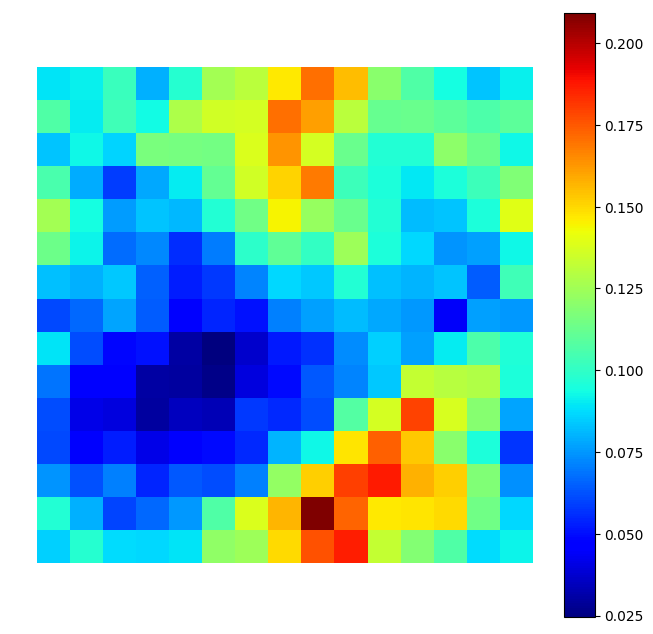

In [7]:
#Calls the SOMZ mode
M = SelfMap(X,Y,Ntop=15,iterations=100,periodic='yes')
#creates a map
M.create_map()
#evaluates it with the Y entered, or anyoher desired colum
M.evaluate_map()
#plots the map
M.plot_map()

mean value from prediction (hex) 18.214390735849058
real value 0.120684


/Users/belaabolfathi/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


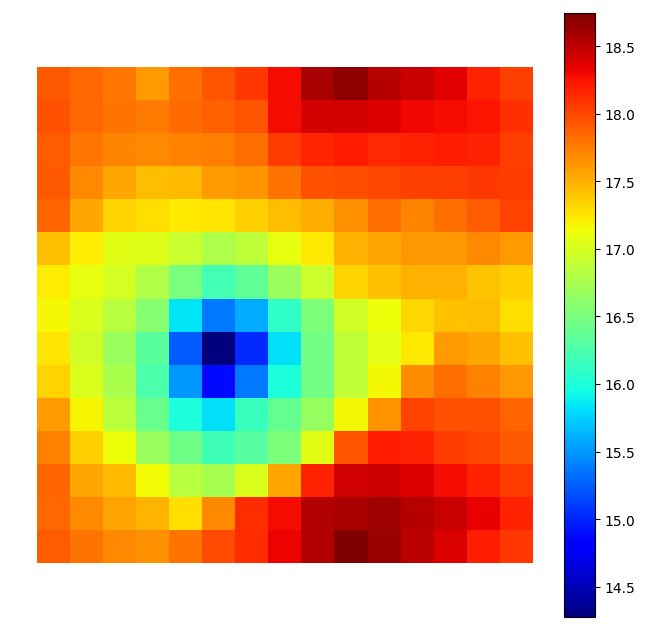

In [9]:
#get prediction values for a test data (just an example on how to do it)
#using a train objetc
values = M.get_vals(X[10])
print('mean value from prediction (hex)', mean(values))
print('real value', Y[10])
#Note we use a low-resoution map and only one map for example purposes
#evaluate other column, for example the 'g' magnitude
M.evaluate_map(inputY=X[:,1])
M.plot_map()

#### Try on cosmoDC2 data

In [11]:
from astropy.table import Table

In [30]:
dc2_griz = Table.read('cosmodc2_colors/dc2_griz_colors.fits', format='fits')
# Convert to numpy array
colnames = dc2_griz.colnames
N, D = len(dc2_griz), len(colnames)
dat_arr = np.empty((N,D))

for i, name in enumerate(colnames):
    dat_arr[:,i] = dc2_griz[name]

In [32]:
dc2_table = Table.read('cosmodc2_colors/dc2_processed_table.fits', format='fits')
# Convert to numpy array
dc2_redshifts = np.array(dc2_table['redshift'])

In [36]:
X = dat_arr[::50]
Y = dc2_redshifts[::50]

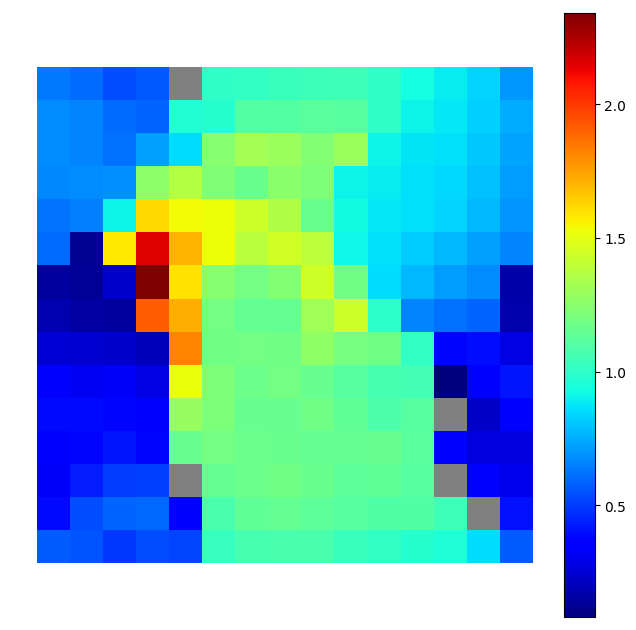

In [38]:
#Calls the SOMZ mode
M = SelfMap(X,Y,Ntop=15,iterations=5,periodic='yes')
#creates a map
M.create_map()
#evaluates it with the Y entered, or anyoher desired colum
M.evaluate_map()
#plots the map
M.plot_map()

### Going through each part of the module

In [178]:
N = 100
nDim = 3
nside = 28
nIter = 30
X = np.random.uniform(size=(N,nDim))
Y = np.random.uniform(size=N)

`SOMz`

In [6]:
somz = SelfMap(X,Y, topology='grid', som_type='online', Ntop=nside, iterations=nIter, 
               periodic='yes', dict_dim='', astart=0.8, aend=0.5, importance=None)

In [7]:
import sys
sys.path.append('/Users/belaabolfathi/Documents/repos/pz_bayes/python')

import som

`pz_bayes`

In [8]:
grid = som.Grid(-nside, -nside)

Compare grid spacing for both codes:

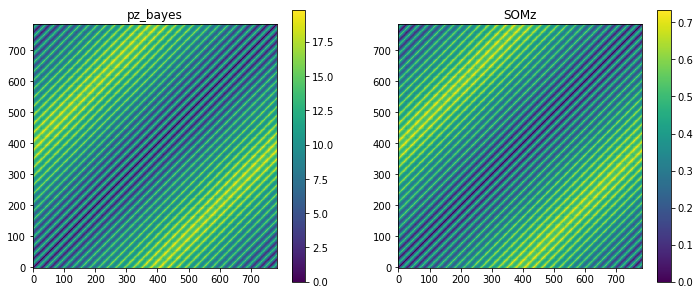

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs = axs.ravel()

im0 = axs[0].imshow(grid.separations, origin='lower')
axs[0].set_title('pz_bayes')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(somz.distLib, origin='lower')
axs[1].set_title('SOMz')
fig.colorbar(im1, ax=axs[1]);

#### `create_map()`: initialize map weights

Randomly initialize weights:

In [11]:
weights = np.random.rand(nDim, somz.npix) + X[0][0]

<IPython.core.display.Javascript object>


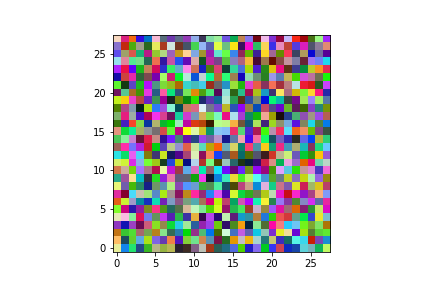

In [102]:
# Initial weight values
plt.imshow(weights.T.reshape(nside, nside, nDim), origin='lower');

In [125]:
 np.min(weights), np.max(weights)

(0.5623600412108546, 1.5622038208040414)

pz_bayes weights

In [218]:
sigs = np.std(X, axis=0)
weights_pz =  sigs.reshape(-1, 1) * np.random.normal(size=(nDim, grid.size))

<IPython.core.display.Javascript object>


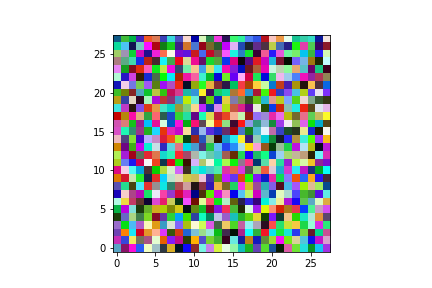

In [123]:
# Initial weight values
plt.imshow(weights_pz.T.reshape(nside, nside, nDim), origin='lower');

In [126]:
np.min(weights_pz), np.max(weights_pz)

(-0.9555615344782046, 1.0283053730294582)

Look at the learning rate and sigma widths.

#### SOMz

(see Matias' paper on how learing rate and sigma are defined: https://arxiv.org/pdf/1312.5753.pdf)

In [13]:
NT = nIter * N
# Initial width of neighborhood
sigma0 = np.max(somz.distLib)
# Smallest non-zero map distance separation
sigma_single = np.min(somz.distLib[np.where(somz.distLib > 0.)])

In [14]:
tt = 0
somz_alphas = np.empty(nIter)
somz_sigmas = np.empty(nIter)
for it in range(nIter):
    alpha = get_alpha(tt, somz.aps, somz.ape, NT)
    sigma = get_sigma(tt, sigma0, sigma_single, NT)
    # tt increases by N after each epoch
    somz_alphas[it] = alpha
    somz_sigmas[it] = sigma
    for i in range(N):
        tt += 1

#### pz_bayes

In [15]:
eta = 0.5
scale = np.max(grid.separations)
pz_alphas = np.empty(nIter)
pz_sigmas = np.empty(nIter)
for it in range(nIter):
    learn_rate = eta ** (it / nIter)
    gauss_width = scale ** (1 - it / nIter)
    pz_alphas[it] = learn_rate
    pz_sigmas[it] = gauss_width

Compare evolution of learning rate and neighborhood function for each code:

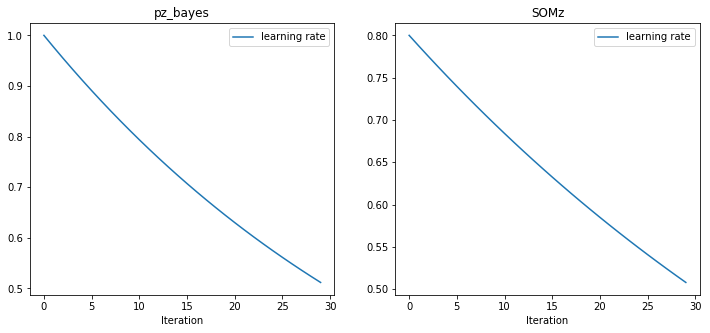

In [16]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs = axs.ravel()

im0 = axs[0].plot(pz_alphas, label='learning rate')
axs[0].set_xlabel('Iteration')
axs[0].set_title('pz_bayes')
axs[0].legend()

im1 = axs[1].plot(somz_alphas, label='learning rate')
axs[1].set_xlabel('Iteration')
axs[1].set_title('SOMz')
axs[1].legend();

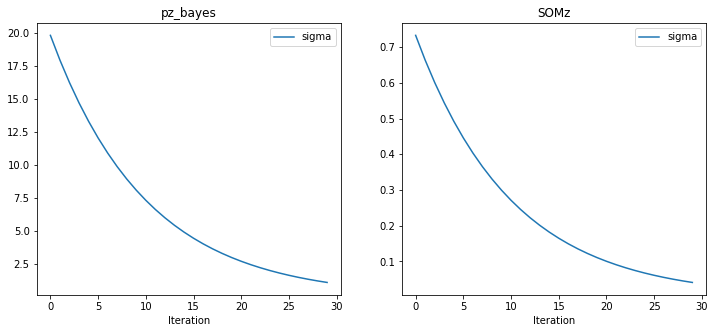

In [17]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs = axs.ravel()

im0 = axs[0].plot(pz_sigmas, label='sigma')
axs[0].set_xlabel('Iteration')
axs[0].set_title('pz_bayes')
axs[0].legend()

im1 = axs[1].plot(somz_sigmas, label='sigma')
axs[1].set_xlabel('Iteration')
axs[1].set_title('SOMz')
axs[1].legend();

In [18]:
np.min(somz.distLib), np.max(somz.distLib), np.min(grid.separations), np.max(grid.separations)

(0.0, 0.7332959212304937, 0.0, 19.79898987322333)

In [80]:
sigma0, scale

(0.7332959212304937, 19.79898987322333)

In [19]:
(0.035 - 0.005) / 0.733, (20 - 2.5) / 19.8

(0.040927694406548434, 0.8838383838383838)

#### Look at how weights change in time

`SOMz`

In [43]:
def som_best_cell(inputs, return_vals=1):
        """
        Return the closest cell to the input object
        It can return more than one value if needed
        """
        activations = numpy.sum(somz.importance.reshape(-1,1) *
            (np.tile(inputs, (somz.npix, 1)).T - weights) ** 2, axis=0)
        if return_vals == 1:
            best = np.argmin(activations)
            return best, activations
        else:
            best_few = numpy.argsort(activations)
            return best_few[0:return_vals], activations

In [90]:
best, activation = som_best_cell(X[99])

In [91]:
def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

<IPython.core.display.Javascript object>


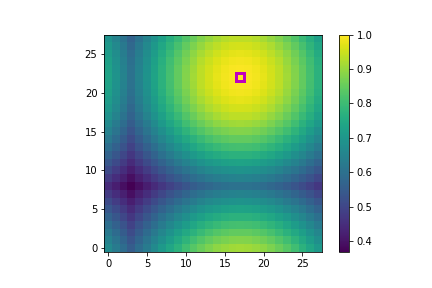

In [97]:
plt.imshow(h(best, somz.distLib, sigma0).reshape(nside, nside), origin='lower')
x = best % nside
y = best // nside
highlight_cell(x,y, color="m", linewidth=3)
plt.colorbar();

<IPython.core.display.Javascript object>


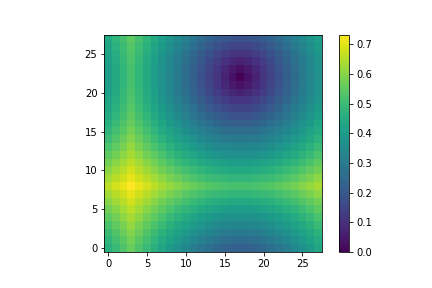

In [98]:
plt.imshow(somz.distLib[best].reshape(nside, nside), origin='lower')
plt.colorbar();

<IPython.core.display.Javascript object>


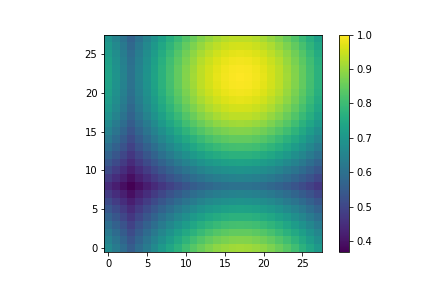

In [99]:
plt.imshow(np.exp(-(somz.distLib[best] ** 2) / sigma0 ** 2).reshape(nside, nside), 
           origin='lower')
plt.colorbar();

Look at the evolution of the neighborhood function as each input vector is introduced to the map during interation = 1:

<IPython.core.display.Javascript object>


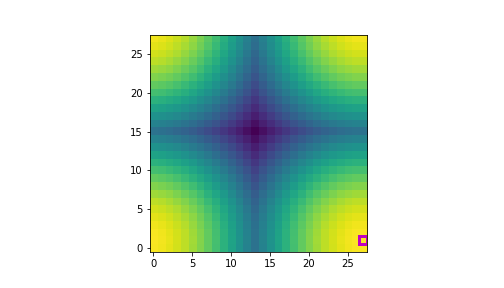

In [103]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
for i in range(N):
    best, activation = som_best_cell(X[index_random[i]])
    im = plt.imshow(h(best, somz.distLib, sigma0).reshape(nside, nside), origin='lower')
    x = best % nside
    y = best // nside
    hc = highlight_cell(x,y, color="m", linewidth=3)
    
    container.append([im, hc])
    
    an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                repeat_delay=2000)

Now look at evolution of neighborhood function for all iterations (and every 20 input vectors):

<IPython.core.display.Javascript object>


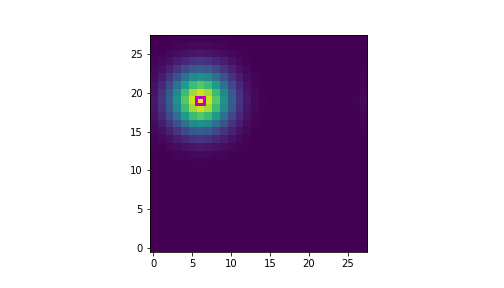

In [118]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
for it in range(nIter):
    for i in np.arange(start=0, stop=N, step=20):
        best, activation = som_best_cell(X[index_random[i]])
        im = plt.imshow(h(best, somz.distLib, somz_sigmas[it]).reshape(nside, nside), origin='lower')
        x = best % nside
        y = best // nside
        hc = highlight_cell(x,y, color="m", linewidth=3)

        container.append([im, hc])

        an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                    repeat_delay=2000)

`pz_bayes`

In [127]:
def h_pz(best, sigma):
    return(np.exp(-0.5 * (grid.separations[best] / sigma) ** 2))

def som_best_cell_pz(inputs):
    dx = inputs.reshape(-1, 1) - weights_pz
    distsq = np.sum(dx ** 2, axis=0)
    return(np.argmin(distsq))

Evolution of neighborhood for iteration = 1:

<IPython.core.display.Javascript object>


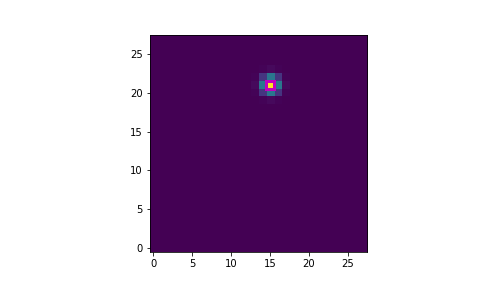

In [131]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
for i in range(N):
    best = som_best_cell_pz(X[index_random[i]])
    im = plt.imshow(h_pz(best, sigma0).reshape(nside, nside), origin='lower')
    x = best % nside
    y = best // nside
    hc = highlight_cell(x,y, color="m", linewidth=3)
    
    container.append([im, hc])
    
    an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                repeat_delay=2000)

Now look at evolution of neighborhood function for all iterations (and every 20 input vectors):

<IPython.core.display.Javascript object>


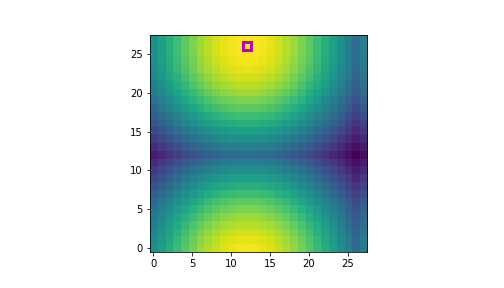

In [132]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
for it in range(nIter):
    for i in np.arange(start=0, stop=N, step=20):
        best = som_best_cell_pz(X[index_random[i]])
        im = plt.imshow(h_pz(best, pz_sigmas[it]).reshape(nside, nside), origin='lower')
        x = best % nside
        y = best // nside
        hc = highlight_cell(x,y, color="m", linewidth=3)

        container.append([im, hc])

        an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                    repeat_delay=2000)

Now let's look at how the weights are updated over time.

`SOMz`

<IPython.core.display.Javascript object>


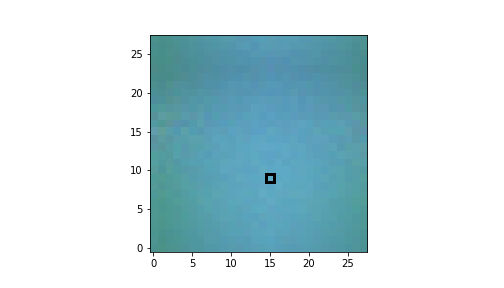

In [217]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
weights = np.random.rand(nDim, somz.npix) + X[0][0]
for it in range(somz.nIter):
    index_random = random.sample(range(somz.np), somz.np)
    for i in np.arange(0,100,20):
        inputs = X[index_random[i]]
        best, activation = som_best_cell(inputs)
        weights += somz_alphas[it] * h(best, somz.distLib, somz_sigmas[it]) * np.transpose(
            (inputs - np.transpose(weights)))

        im = plt.imshow(weights.T.reshape(nside, nside, nDim), origin='lower')
        x = best % nside
        y = best // nside
        hc = highlight_cell(x,y, color="k", linewidth=3)

        container.append([im, hc])

        an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                    repeat_delay=2000)

`pz_bayes`

<IPython.core.display.Javascript object>


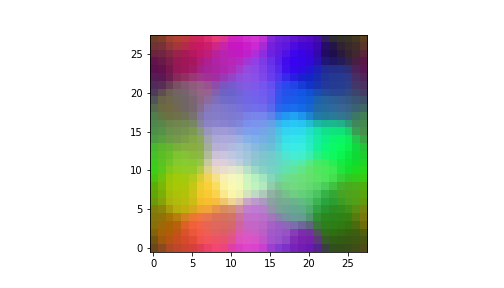

In [236]:
fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
sigs = np.std(X, axis=0)
weights_pz =  sigs.reshape(-1, 1) * np.random.normal(size=(nDim, grid.size))
for it in range(nIter):
    for i in range(N):
        inputs = X[index_random[i]]
        best = som_best_cell_pz(inputs)
        weights_pz += pz_alphas[it] * np.exp(-0.5 * (grid.separations[best] / 
                                                     pz_sigmas[it]) ** 2) * (inputs.reshape(-1,1) - weights_pz)
        
plt.imshow(weights_pz.T.reshape(nside, nside, nDim), origin='lower')

<IPython.core.display.Javascript object>


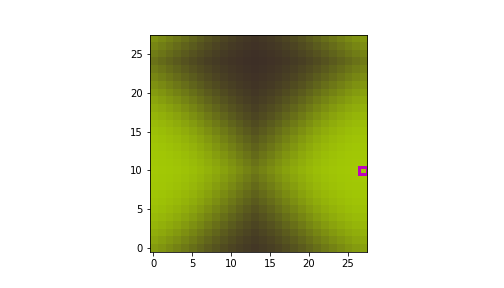

In [237]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
sigs = np.std(X, axis=0)
weights_pz =  sigs.reshape(-1, 1) * np.random.normal(size=(nDim, grid.size))
for it in range(nIter):
    for i in np.arange(start=0, stop=N, step=50):
        inputs = X[index_random[i]]
        best = som_best_cell_pz(inputs)
        weights_pz += pz_alphas[it] * np.exp(-0.5 * (grid.separations[best] / 
                                                     pz_sigmas[it]) ** 2) * (inputs.reshape(-1,1) - weights_pz)
        
        im = plt.imshow(weights_pz.T.reshape(nside, nside, nDim), origin='lower')
        x = best % nside
        y = best // nside
        hc = highlight_cell(x,y, color="m", linewidth=3)

        container.append([im, hc])

        an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                    repeat_delay=2000)

It keeps going back and forth between the same two cells...

Let's see if anything changes with a different initialization of the node weights:

<IPython.core.display.Javascript object>


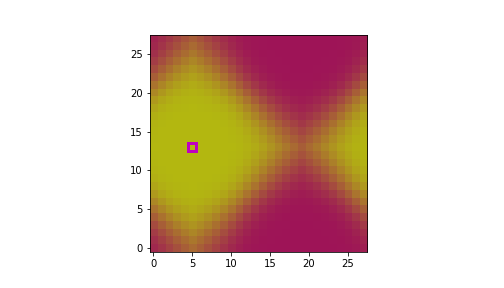

In [238]:
%matplotlib notebook
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,4))
container = []
index_random = random.sample(range(N), N)
weights_pz = np.random.rand(nDim, nside ** 2) + X[0][0]
for it in range(nIter):
    for i in np.arange(start=0, stop=N, step=50):
        inputs = X[index_random[i]]
        best = som_best_cell_pz(inputs)
        weights_pz += pz_alphas[it] * np.exp(-0.5 * (grid.separations[best] / 
                                                     pz_sigmas[it]) ** 2) * (inputs.reshape(-1,1) - weights_pz)
        
        im = plt.imshow(weights_pz.T.reshape(nside, nside, nDim), origin='lower')
        x = best % nside
        y = best // nside
        hc = highlight_cell(x,y, color="m", linewidth=3)

        container.append([im, hc])

        an = animation.ArtistAnimation(fig, container, interval=1000, blit=True,
                                    repeat_delay=2000)